In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import optax
import itertools
import equinox as eqx
import jax.numpy as jnp
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

from solvers import FD_2D
from tqdm import tqdm
from jax import device_put
from functools import partial
from IPython import display
from transforms import utilities, cheb
from collections import namedtuple
from jax.lax import scan, dot_general
from jax import device_put, clear_caches, tree_util
from architectures import DilResNet, UNet
from transforms import library_of_transforms as lft
from jax import config, random, grad, vmap, tree_map, tree_leaves, jit
from jax.experimental import sparse as jsparse

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
@jit
def spsolve_scan(carry, n):
    A, r = carry
    A_bcsr = jsparse.BCSR.from_bcoo(A)
    Ar = jsparse.linalg.spsolve(A_bcsr.data[n], A_bcsr.indices[n], A_bcsr.indptr[n], r[n])
    return [A, r], Ar

def res_func(A, B, res):
    _, Ar = scan(spsolve_scan, [A, res], jnp.arange(A.shape[0]))
    Ar = jnp.array(Ar)
    B_Ar = jsparse.bcoo_dot_general(A, B - Ar, dimension_numbers=((2, 1), (0, 0)))
    numerator = jnp.sqrt(jnp.einsum('bi, bi -> b', B - Ar, B_Ar))
    denominator = jnp.sqrt(jnp.einsum('bi, bi -> b', Ar, res))
    value = numerator / denominator
    return value

def random_polynomial_2D(x, y, coeff):
    res = 0
    for i, j in itertools.product(range(coeff.shape[0]), repeat=2):
        res += coeff[i, j]*jnp.exp(2*jnp.pi*x*i*1j)*jnp.exp(2*jnp.pi*y*j*1j)/(1+i+j)**2
    res = jnp.real(res)
    return res

def get_functions(key):
    c_ = random.normal(key, (1, 5, 5), dtype=jnp.complex128)
    rhs = lambda x, y, c=c_[0]: random_polynomial_2D(x, y, c)
    return rhs

In [4]:
def dataset(grid, N_samples, key):
    keys = random.split(key, N_samples)
    A, rhs = [], []
    
    for key in keys:
        rhs_sample, A_sample = FD_2D(grid, [lambda x, y: 1, get_functions(key)])
        A.append(A_sample.reshape(1, grid**2, -1))
        rhs.append(rhs_sample)
    A = device_put(jsparse.bcoo_concatenate(A, dimension=0))
    return A, jnp.array(rhs)

In [5]:
def get_exact_solution(A, rhs, grid, N_samples):
    A_bcsr = jsparse.BCSR.from_bcoo(A)
    u_exact = jnp.stack([jsparse.linalg.spsolve(A_bcsr.data[n], A_bcsr.indices[n], A_bcsr.indptr[n], rhs[n].reshape(-1,)) for n in range(N_samples)]).reshape(N_samples, grid, grid)
    return u_exact

In [6]:
def get_UNet(key, features_train, grid):
    input = features_train
    D = len(input.shape[1:])
    
    input_shape = input.shape[0]
    N_convs = 4
    N_features_out = 1
    kernel_size = 3
    
    if grid <= 64:
        N_features = 10
    else:
        N_features = grid // 4
        
        
    model = UNet.UNet(D, input.shape[1], [input_shape, N_features, N_features_out], kernel_size, N_convs, key, depth=3)
    
    # Parameters of training
    N_epoch = 150
    if grid <= 64:
        batch_size = 32
    else:
        batch_size = 1024 // grid

    if grid < 128:
        learning_rate = 1e-3
    else:
        learning_rate = 8e-4
    
    model_data = {
        "model_name": "UNet",
        "model": model
    }
    
    optimization_specification = {
        "learning_rate": learning_rate,
        "compute_loss": lambda carry, indices: compute_loss_scan(carry, indices),
        "make_step": lambda carry, indices, optim: make_step_scan(carry, indices, optim),
        "N_epochs": N_epoch,
        "batch_size": batch_size, 
        "res_func": lambda A, model, input: res_func(A, model, input) 
    }
    return model_data, optimization_specification

In [7]:
def FCG(A, features, targets, model, N_iter, m_max, optimization_specification, eps=1e-30):
    def get_mi(i, m_max):
        if i == 0:
            return 0
        else:
            return jnp.maximum(1, i % (m_max+1))

    samples = features.shape[0]
    n = features.shape[-1]

    X, P = jnp.zeros((samples, n, N_iter+1)), jnp.zeros((samples, n, N_iter))
    R = jnp.zeros((samples, n, N_iter+1))
    S = jnp.zeros((samples, n, N_iter))
    x0 = random.normal(random.PRNGKey(2), (samples, n)) 

    X = X.at[:, :, 0].set(x0)
    f = features
    R = R.at[:, :, 0].set(f - jsparse.bcoo_dot_general(A, x0, dimension_numbers=((2, 1),(0, 0))))
    train_losses, train_residuals = [], []
    train_residuals_std = []

    grid = int(n**0.5)
    h = 1. / grid

    values, values_std = [], []

    for idx in tqdm(range(N_iter)):
        norm = jnp.linalg.norm(R[:, :, idx], axis=1)
        
        train_data = [jnp.einsum('bi,b->bi', R[:, :, idx], 1./norm)]
        if type(model) != type(lambda x: x):
            output = vmap(model, in_axes=(0))(jnp.einsum('bi, b->bi', R[:, :, idx], 1/norm)[:, None].reshape(-1, 1, grid, grid))[:, 0].reshape(-1, grid**2)
            U = jnp.einsum('bi, b->bi', output, norm)

        else:
            history_train = []
            U = vmap(model)(R[:, :, idx])

        value = optimization_specification['res_func'](A,  U, R[:, :, idx])
        
        values.append(value.mean())
        values_std.append(st.t.interval(confidence=0.99, df=len(value)-1, 
                                                 loc=values[-1], scale=st.sem(value)))

        j = get_mi(idx, m_max)
        P = P.at[:, :, idx].set(U)
        for k in range(j):
            alpha = - jnp.einsum('bj, bj->b', S[:, :, idx-k-1], U) / (jnp.einsum('bj, bj->b', S[:, :, idx-k-1], P[:, :, idx-k-1]) + eps)
            P = P.at[:, :, idx].add(jnp.einsum('b, bj->bj', alpha, P[:, :, idx-k-1]))
        
        S = S.at[:, :, idx].set(jsparse.bcoo_dot_general(A, P[:, :, idx], dimension_numbers=((2, 1),(0, 0))))
        beta = jnp.einsum('bj, bj -> b', P[:, :, idx], R[:, :, idx]) / (jnp.einsum('bj, bj -> b', S[:, :, idx], P[:, :, idx]) + eps)

        X = X.at[:, :, idx+1].set(X[:, :, idx] + jnp.einsum('b, bj->bj', beta, P[:, :, idx]))
        R = R.at[:, :, idx+1].set(R[:, :, idx] - jnp.einsum('b, bj->bj', beta, S[:, :, idx]))
        
    return P, R, X, values, values_std

In [8]:
@jit
def compute_loss_scan(carry, indices):
    model, A, x, error, N_repeats = carry
    A, x, error = A[indices // N_repeats], x[indices], error[indices]
    B = vmap(lambda z: model(z), in_axes=(0,))(x[:, None, :])[:, 0].reshape(x.shape[0], -1)
    B_e = jsparse.bcoo_dot_general(A, B - error, dimension_numbers=((2, 1), (0, 0)))
    A_e = jsparse.bcoo_dot_general(A, error, dimension_numbers=((2, 1), (0, 0)))
    return carry, jnp.mean(jnp.sqrt(jnp.einsum('bi, bi -> b', B - error, B_e) / jnp.einsum('bi, bi -> b', error, A_e)))

def compute_loss(model, A, x, error):
    B = vmap(lambda z: model(z), in_axes=(0,))(x[:, None, :])[:, 0].reshape(x.shape[0], -1)
    B_e = jsparse.bcoo_dot_general(A, B - error, dimension_numbers=((2, 1), (0, 0)))
    A_e = jsparse.bcoo_dot_general(A, error, dimension_numbers=((2, 1), (0, 0)))
    return jnp.mean(jnp.sqrt(jnp.einsum('bi, bi -> b', B - error, B_e) / jnp.einsum('bi, bi -> b', error, A_e)))

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step_scan(carry, indices, optim):
    model, A, r, error, opt_state, N_repeats = carry
    loss, grads = compute_loss_and_grads(model, A[indices // N_repeats], r[indices], error[indices])
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [model, A, r, error, opt_state, N_repeats], loss

def train_on_epoch(key, batch_size, A, model, x, error, opt_state, make_step, N_repeats):
    N_samples = len(x)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)

    n_batches = N_samples // batch_size
    
    carry = [model, A, x, error, opt_state, N_repeats]
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))
    data, epoch_loss = scan(make_step, carry, n)
    model = data[0]
    opt_state = data[4]
    return epoch_loss, model, opt_state

def test_on_epoch(key, batch_size, A, model, x, error, compute_loss, N_repeats):
    N_samples = len(x)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)

    n_batches = N_samples // batch_size
    
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))
    carry = [model, A, x, error, N_repeats]
    data, epoch_loss = scan(compute_loss, carry, n)
    return epoch_loss

def train_model(model, A, x, error, optimization_specification, N_repeats):
    model = model
    history = []
    history_test = []

    c = x.shape[0] // optimization_specification['batch_size']
    keys = [value * c for value in np.arange(50, 1000, 50)]
    values = [0.5, ] * len(keys)
    dict_lr = dict(zip(keys, values))

    sc = optax.piecewise_constant_schedule(optimization_specification['learning_rate'], dict_lr)
    optimizer = optax.adamw(sc, weight_decay=1e-2)

    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    make_step = lambda a, b: optimization_specification['make_step'](a, b, optimizer)
    
    for it in tqdm(range(optimization_specification['N_epochs'])):
        key = random.PRNGKey(it)
        loss, model, opt_state = train_on_epoch(key, optimization_specification['batch_size'], A, model, x, error, opt_state, make_step, N_repeats)
        history.append(loss)
    
    return model, history

In [9]:
grid = 64
samples_div = 1
N_samples = grid // samples_div

A_train, rhs_train = dataset(grid=grid, N_samples=N_samples, key=random.PRNGKey(42))
u_exact_train = get_exact_solution(A_train, rhs_train, grid=grid, N_samples=N_samples)

A_train.shape, rhs_train.shape, u_exact_train.shape

((64, 4096, 4096), (64, 4096), (64, 64, 64))

In [10]:
N_repeats = 100
m_max = 20
h = 1. / grid

model_ = lambda x: x
optimization_specification = {"res_func": lambda A, B, input: res_func(A, B, input)}
_, R_, X_, _, _ = FCG(A_train, rhs_train, u_exact_train.reshape(-1, grid**2)*h**2, model_, N_repeats-1, m_max, optimization_specification)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [10:04<00:00,  6.11s/it]


In [11]:
residuals = R_.transpose(0, 2, 1).reshape(-1, grid, grid)
norm = jnp.linalg.norm(residuals, axis=(1, 2))
residuals = jnp.einsum('bij, b -> bij', residuals, 1./norm)
error = (jnp.repeat(u_exact_train.reshape(-1, grid**2)[:, :, None], N_repeats, axis=2) - X_).transpose(0, 2, 1).reshape((N_samples * N_repeats, -1, grid))
error = jnp.einsum('bij, b -> bij', error, 1./norm).reshape(N_samples * N_repeats, -1)

residuals.shape, error.shape

((6400, 64, 64), (6400, 4096))

In [12]:
test_size = (N_repeats + 1) * 1
model_data, optimization_specification = get_UNet(random.PRNGKey(40), residuals[0][None, ...], grid)
model, history = train_model(model_data['model'], A_train, residuals, error, optimization_specification, N_repeats)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [15:37<00:00,  6.25s/it]


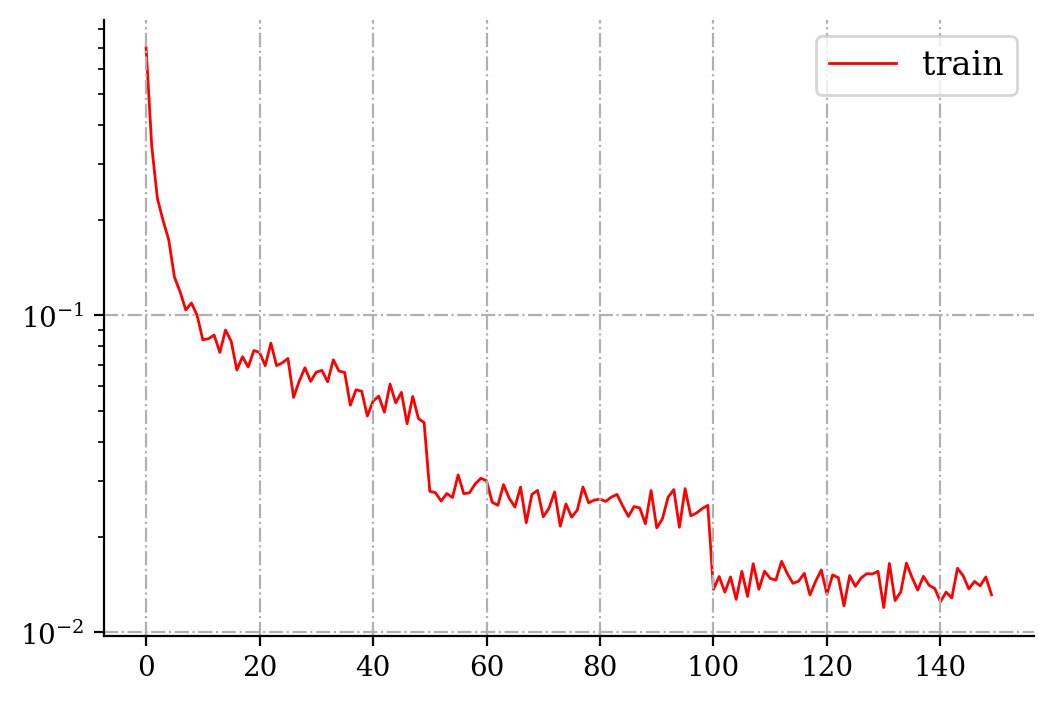

In [13]:
plt.rcParams['font.family'] = 'serif'
          
fig = plt.figure(figsize=(6, 4))

plt.yscale('log')
plt.plot([jnp.mean(jnp.array(epoch)) for epoch in history], linestyle='-', color='red', linewidth=1, zorder=1, label=r'train')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['right'].set_visible(False)

plt.grid(linestyle='-.')
plt.legend(loc='best', fontsize="12");

In [14]:
N_samples = 20
N_iter = min(int(grid*2.5), 400)
A_test, rhs_test = dataset(grid=grid, N_samples=N_samples, key=random.PRNGKey(12))
A_bcsr = jsparse.BCSR.from_bcoo(A_test)
u_exact_test = jnp.stack([jsparse.linalg.spsolve(A_bcsr.data[n], A_bcsr.indices[n], A_bcsr.indptr[n], rhs_test[n].reshape(-1,)) for n in range(N_samples)])

del A_bcsr
clear_caches()

_, R, _, values, values_std = FCG(A_test, rhs_test, u_exact_test*h**2, model, N_iter, m_max, optimization_specification)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [05:56<00:00,  2.23s/it]


In [15]:
model_ = lambda x: x
_, R_, _, values_, _ = FCG(A_test, rhs_test.reshape(-1, grid**2), u_exact_test*h**2, model_, N_iter, m_max, optimization_specification)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [05:02<00:00,  1.89s/it]


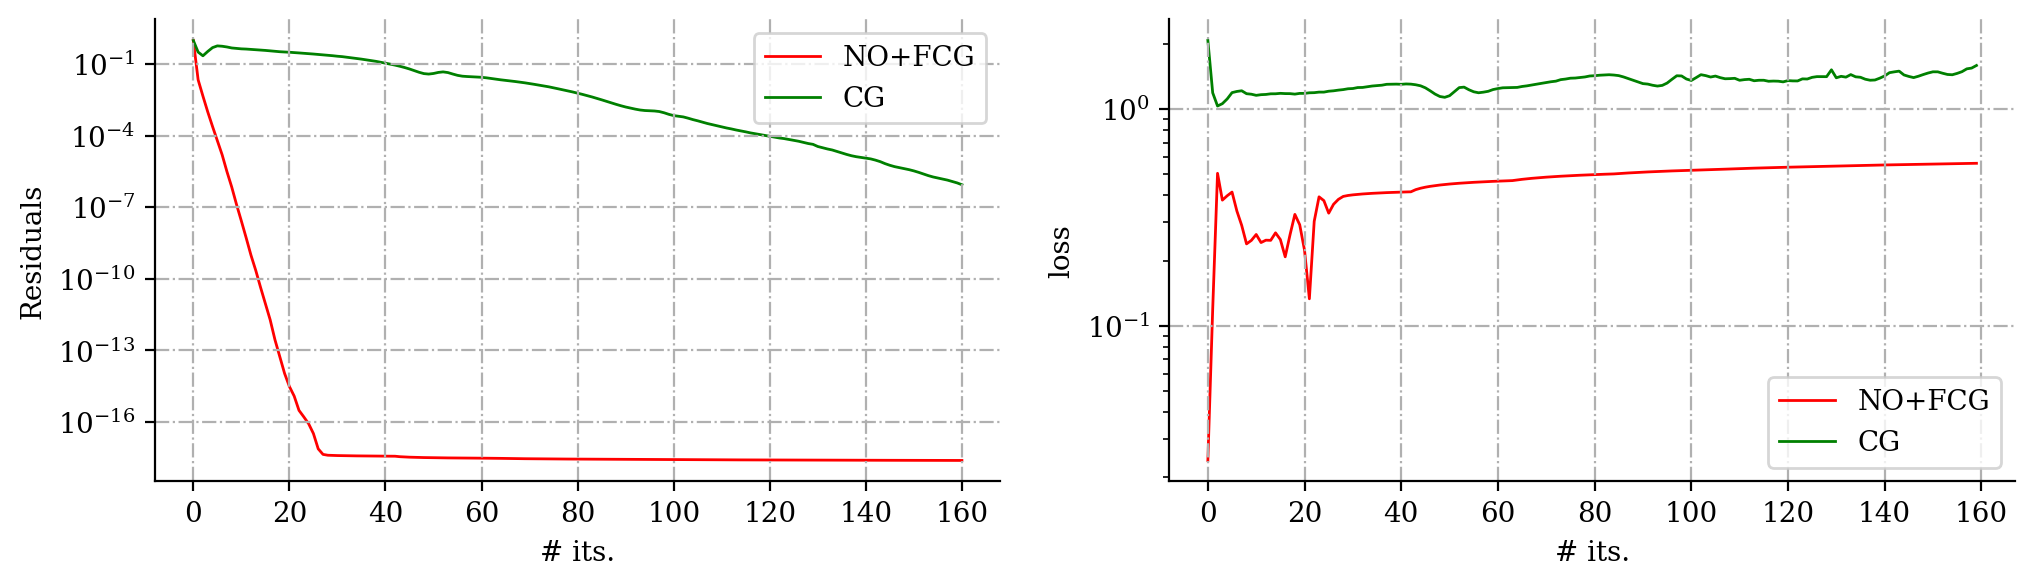

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

norm = jnp.linalg.norm(R[:, :, 0], axis=1)
norm_ = jnp.linalg.norm(R_[:, :, 0], axis=1)

R = jnp.einsum('bij, b -> bij', R, 1. / norm)
R_ = jnp.einsum('bij, b -> bij', R_, 1. / norm_)

ax[0].set_yscale('log')
ax[0].plot(jnp.mean(jnp.linalg.norm(R, axis=1), axis=0), linestyle='-', color='red', linewidth=1, zorder=1, label=r'NO+FCG')
ax[0].plot(jnp.mean(jnp.linalg.norm(R_, axis=1), axis=0), linestyle='-', color='green', linewidth=1, zorder=1, label=r'CG')
ax[0].grid(linestyle='-.')
ax[0].set_ylabel(r'Residuals')
ax[0].set_xlabel(r'# its.')

ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(True)
ax[0].spines['right'].set_visible(False)

ax[0].legend(loc='best');

ax[1].set_yscale('log')
ax[1].plot(values, linestyle='-', color='red', linewidth=1, zorder=1, label=r'NO+FCG')
ax[1].plot(values_, linestyle='-', color='green', linewidth=1, zorder=1, label=r'CG')
ax[1].grid(linestyle='-.')
ax[1].set_ylabel(r'loss')
ax[1].set_xlabel(r'# its.')

ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(True)
ax[1].spines['right'].set_visible(False)

ax[1].legend(loc='best');